In [1]:
from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from accretion import*
from vrel import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})



def m_dot_DMhalo_veffA(z, m):  
    
    y = np.array(m, dtype = np.longdouble)
    
    if z < 0 or z == 0:
        print("i =",   i, ",", "z =", z)
        
    def c_s(z):
        β = 1.72
        z_dec = 130
        return  5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)

   
    def v_rel_digitized(z):
        return  vrel_extrapolation(z) * 1e3 *  (yr/pc)
   
    
    def Mach_number(z):
        return v_rel_digitized(z)/c_s(z)
     
    
    def v_eff(z): #Here, v_eff = v_eff, A
        if Mach_number(z) > 1:
            return  c_s(z) * (((16/np.sqrt(2 * np.pi)) * (Mach_number(z)**3))**(1/6))  
        else:
            return  c_s(z) * np.sqrt(1 + (Mach_number(z)**2))
   
   
     
    def M_halo(z, m, f_pbh):
        z_cut_halo = (3 * 1000 * f_pbh) - 1
        if z < z_cut_halo:
            return 3 * y * (((1+z)/1000)**(-1))
        else:
            return 3 * y * (((1+z_cut_halo)/1000)**(-1))
           
    
    
    
    def k(z, m):
        return 0.22 * ((1+z)/1000) * (M_halo(z, m, f_pbh)**(2/3)) * (((1e3 * (yr/pc))/v_eff(z))**2)

    
    if k(z, m) >= 2:
        def λ(z, m):
            def β_cap_nohalo(z, m):
                def x_e(z):
                    if z >= z_rec:
                        return 1
                    else:
                        return e_fraction
                return  1e-4 * y * (((1+z)/1000)**(3/2)) *  (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

            def x_cr(z, m):
                return ((-1 + np.sqrt(1 + β_cap_nohalo(z, m)))/β_cap_nohalo(z, m))

            return np.exp((9/2)/(3 + β_cap_nohalo(z, m)**(0.75))) * (x_cr(z, m)**2)

        
    else:
        def λ(z, m):
            alpha = 2.25
            p = 3 - alpha
            power = p/(1-p)
            
            def β_cap_updated(z, m):
                def x_e(z):
                    if z >= z_rec:
                        return 1
                    else:
                        return e_fraction
                return  1e-4 * M_halo(z, m, f_pbh) * (((1+z)/1000)**(3/2)) *  (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

            
            def β_cap_halo(z, m):
                return (k(z, m)**power) * β_cap_updated(z, m)


            def x_cr_halo(z, m):
                return ((k(z, m)/2)**power)  * ((-1 + np.sqrt(1 + β_cap_halo(z, m)))/β_cap_halo(z, m)) #((-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m))

            def gamma_bar(z, m):
                return ((1 + 10 * β_cap_halo(z, m))**(1/10)) * np.exp(2 - k(z, m)) * ((k(z, m)/2)**2)
            
            return (gamma_bar(z, m)**power) * np.exp((9/2)/(3 + β_cap_halo(z, m)**(0.75))) * (x_cr_halo(z, m)**2)
        
    
        
    return  0.016 * λ(z, m) * (((1+z)/1000)) * y  * (((5.74e3 * (yr/pc))/v_eff(z))**3) 

        

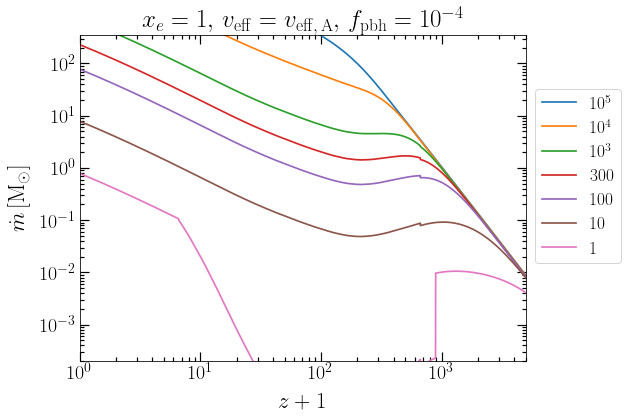

In [2]:
colors = ['C0', 'C1','C2','C3','C4', 'C5']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1e4, 1, 10000)
m_dot_arr = np.zeros(len(z_arr))



e_fraction = 1
f_pbh = 1e-4

for i, m in enumerate(mi_arr):
    for i, z in enumerate(z_arr):
        m_dot_arr[i] = m_dot_DMhalo_veffA(z, m)
    plt.loglog(z_arr, m_dot_arr)
    

plt.xlabel('$z+1$',  fontsize = 23, labelpad = 10)
plt.ylabel('$\dot m \, \mathrm{[M_{\odot}]}$', fontsize = 23, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( [ '$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$'],
           title_fontsize = 12, loc = (1.02, 0.3), prop = {"size":17.3})
plt.ylim(2e-4, 350)
plt.xlim(1, 5000)
plt.title('$x_{e} = 1, \, v_\mathrm{eff} = v_\mathrm{eff,\, A},\, f_\mathrm{pbh} = 10^{-4} $', fontsize = 25, pad = 8)
plt.savefig('m_dot_DMhalo_xe1.pdf', bbox_inches = 'tight')
plt.show()

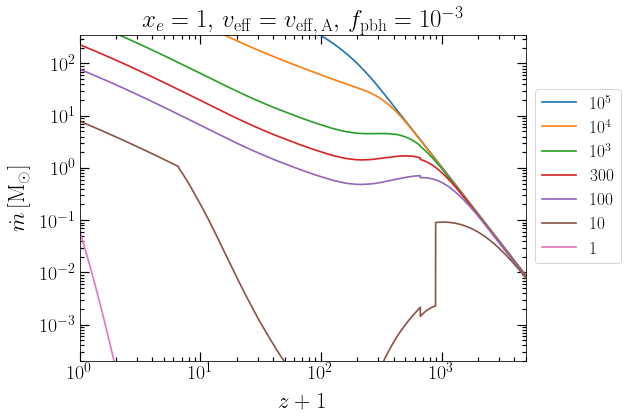

In [3]:
colors = ['C0', 'C1','C2','C3','C4', 'C5']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1e6, 1, 10000)
m_dot_arr = np.zeros(len(z_arr))



e_fraction = 1
f_pbh = 1e-3

for i, m in enumerate(mi_arr):
    for i, z in enumerate(z_arr):
        m_dot_arr[i] = m_dot_DMhalo_veffA(z, m)
    plt.loglog(z_arr, m_dot_arr)
    

plt.xlabel('$z+1$',  fontsize = 23, labelpad = 10)
plt.ylabel('$\dot m \, \mathrm{[M_{\odot}]}$', fontsize = 23, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( [ '$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$'],
           title_fontsize = 12, loc = (1.02, 0.3), prop = {"size":17.3})
plt.ylim(2e-4, 350)
plt.xlim(1, 5000)
plt.title('$x_{e} = 1, \, v_\mathrm{eff} = v_\mathrm{eff,\, A},\, f_\mathrm{pbh} = 10^{-3} $', fontsize = 25, pad = 8)
plt.savefig('m_dot_DMhalo_xe1_2.pdf', bbox_inches = 'tight')
plt.show()
    

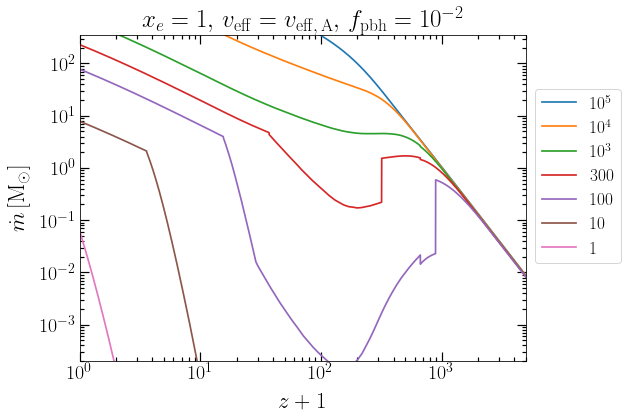

In [4]:
colors = ['C0', 'C1','C2','C3','C4', 'C5']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1e6, 1, 10000)
m_dot_arr = np.zeros(len(z_arr))



e_fraction = 1
f_pbh = 1e-2

for i, m in enumerate(mi_arr):
    for i, z in enumerate(z_arr):
        m_dot_arr[i] = m_dot_DMhalo_veffA(z, m)
    plt.loglog(z_arr, m_dot_arr)
    

plt.xlabel('$z+1$',  fontsize = 23, labelpad = 10)
plt.ylabel('$\dot m \, \mathrm{[M_{\odot}]}$', fontsize = 23, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( [ '$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$'],
           title_fontsize = 12, loc = (1.02, 0.3), prop = {"size":17.3})
plt.ylim(2e-4, 350)
plt.xlim(1, 5000)
plt.title('$x_{e} = 1, \, v_\mathrm{eff} = v_\mathrm{eff,\, A},\, f_\mathrm{pbh} = 10^{-2} $', fontsize = 25, pad = 8)
plt.savefig('m_dot_DMhalo_xe1_3.pdf', bbox_inches = 'tight')
plt.show()
    

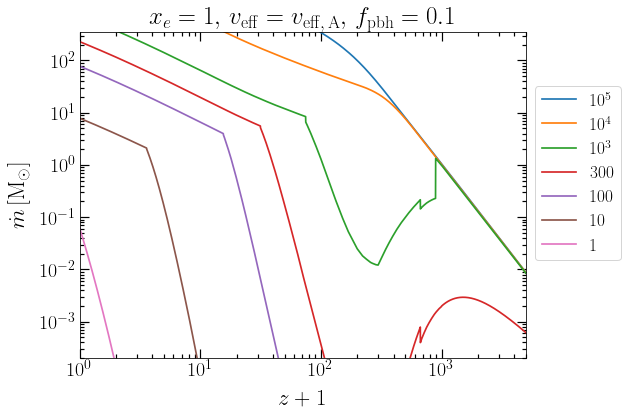

In [5]:
colors = ['C0', 'C1','C2','C3','C4', 'C5']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1e6, 1, 10000)
m_dot_arr = np.zeros(len(z_arr))



e_fraction = 1
f_pbh = 0.1

for i, m in enumerate(mi_arr):
    for i, z in enumerate(z_arr):
        m_dot_arr[i] = m_dot_DMhalo_veffA(z, m)
    plt.loglog(z_arr, m_dot_arr)
    

plt.xlabel('$z+1$',  fontsize = 23, labelpad = 10)
plt.ylabel('$\dot m \, \mathrm{[M_{\odot}]}$', fontsize = 23, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( [ '$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$'],
           title_fontsize = 12, loc = (1.02, 0.3), prop = {"size":17.3})
plt.ylim(2e-4, 350)
plt.xlim(1, 5000)
plt.title('$x_{e} = 1, \, v_\mathrm{eff} = v_\mathrm{eff,\, A},\, f_\mathrm{pbh} = 0.1 $', fontsize = 25, pad = 8)
plt.savefig('m_dot_DMhalo_xe1_4.pdf', bbox_inches = 'tight')
plt.show()
    